## Horizontal displacement of radiosondes

In [1]:

#Horizontal_displacement.ipynb>
import numpy as np
import pandas as pd
from datetime import datetime
import time
import csv
import readline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import os
#from netCDF4 import Dataset, num2date, date2num
import math
import sys
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import xarray
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gc
from numpy import datetime64
import fimex_xarray
from netCDF4 import Dataset

gc.collect()

0

Investigating the output dataset for the AROME model 

In [11]:
config = "/lustre/storeB/project/fou/kl/cerad/Meteorology/AROME-CHERNOBYL/netcdf/cdmGribReaderConfigArome2_5.xml"

file = "/lustre/storeB/project/fou/kl/cerad/Meteorology/AROME-CHERNOBYL/gribml/deter_19860425_00.grbml"

ds = xarray.open_dataset(file, config=config, engine="fimex")
#ds = ds.isel(x=range(0, ds.dims["x"], 10))
#ds = ds.isel(y=range(0, ds.dims["y"], 10))
print(ds)
variables_wind =['x_wind_z','y_wind_z', 'longitude', 'latitude', 'time']
print(ds.variables)
wind_xdir = ds["x_wind_ml"]
wind_ydir = ds["y_wind_ml"]
time = ds["time"]
hybrid = ds["hybrid"]
a = ds["ap"]
print(a)
longitude = ds["longitude"]

latitude = ds["latitude"]


<xarray.Dataset>
Dimensions:                                                                      (
                                                                                  time: 19,
                                                                                  height32: 1,
                                                                                  y: 1429,
                                                                                  x: 1489,
                                                                                  hybrid: 65,
                                                                                  ...
                                                                                  height18: 5,
                                                                                  height9: 1,
                                                                                  height21: 5,
                                                                   

In [17]:
wind_xdir.values

MemoryError: std::bad_alloc

In [13]:
x_wind = wind_xdir.isel(time=2)
y_wind = wind_ydir.isel(time=2)

x_wind1 = wind_xdir.isel(time=2)
y_wind1 = wind_ydir.isel(time=2)


ValueError: x, y, u and v arrays must be the same shape

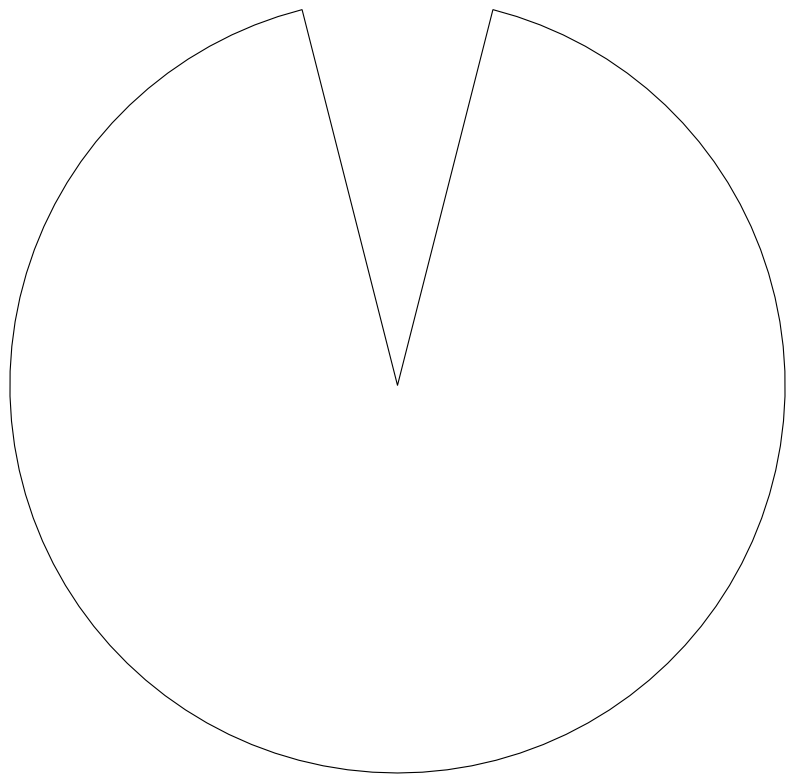

In [14]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.LambertConformal(central_longitude=10, standard_parallels=(54,78))}, figsize=(10,15))
provinces_50m = cfeature.NaturalEarthFeature('cultural',
                                             'admin_1_states_provinces_lines',
                                             '50m',
                                             facecolor='none')
ax.quiver(longitude.values, latitude.values, x_wind.values, y_wind.values, width = 0.005, scale = 70, transform = ccrs.PlateCarree(), color = "red", label = "ensamble member 0")
ax.quiver(longitude.values, latitude.values, x_wind1.values, y_wind1.values, width = 0.005, scale = 70, transform = ccrs.PlateCarree(), label = "ensamble member = 10")
ax.legend()
#ax.set_extent((-10, 60, 40, 75), crs = ccrs.PlateCarree())
ax.set_extent((10,11, 59, 60), crs = ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

In [16]:
x_wind = wind_xdir.sel(pressure = 850.0).isel(time=2)

np = ds["x_wind_pl"]["time"].values[:5]

print("The earliest date in the data is:", ds["x_wind_pl"]["time"].values.min())
print("The latest date in the data is:", ds["x_wind_pl"]["time"].values.max()) 

KeyError: "'pressure' is not a valid dimension or coordinate"

### Bilinnear interpolation

In [38]:
def BilinnerarPoints(filename, lat, lon):
    with Dataset(filename) as ncfile:     
        nc_lat = ncfile['latitude'][:]
        nc_lon = ncfile['longitude'][:]
        
        #find distance between all the latitudes and longitudes in the dataset and the observation latitude
        X=np.sqrt(np.square(nc_lat-lat) + np.square(nc_lon-lon))
        idx=np.where(X == X.min())
        print(idx)
        ix=idx[1] # longitude with smallest distance
        iy=idx[0] # latitude with smallest distance
        #print('ix',ix)
        #print('iy',iy)
        
        #Find nearest neighbors y,x for the latitude 
        iy1=iy
        iy2=iy+1
        if ((nc_lat[iy,ix]-lat) > 0):
            iy2=iy
            iy1=iy-1
        #
        ix1=ix
        ix2=ix+1
        if ((nc_lon[iy,ix]-lon) > 0):
            ix2=ix
            ix1=ix-1

        #Bilinear interpolation coefficients s and t
        s = 1
        if ((nc_lat[iy2,ix1] - nc_lat[iy1,ix1]) > 0):
            s = (lat - nc_lat[iy1,ix]) / (nc_lat[iy2,ix] - nc_lat[iy1,ix])
            print(s)
        
        t = 1
        if ((nc_lon[iy1,ix2] - nc_lon[iy1,ix1]) > 0):
            t = (lon - nc_lon[iy,ix1]) / (nc_lon[iy,ix2] - nc_lon[iy,ix1])
            print(t) 
    
    return s,t,ix1,ix2,iy1,iy2 
        

In [39]:
BilinnerarPoints(filename, 30, 40)

NameError: name 'Dataset' is not defined

In [169]:
def time_interpolate_points(filename, time1):
    
    """
    Innput
    ––––––––––––––––––––––––––––––––––––––––––––
    File or array?
    
    Ourtput
    ––––––––––––––––––––––––––––––––––––––––––––
    A linnear interpolation weight t, and the two corresponding time points
    
    """
    ds = xarray.open_dataset(filename)
    
    timepoints = ds["x_wind_pl"]["time"].values

    k = min(timepoints, key=lambda x: abs(x - time1))
    print(k)

    # Selecting the time point with minimum distance
    it=np.where(timepoints == k)
    it = int(it[0])
    
    t1=it
    t2=it+1
    
    if ((timepoints[it]-time1) > 0):
        t2=it
        print("here")
        t1=it-1
        
    t = 1
    if ((timepoints[t2] - timepoints[t1]) > 0):
        t = (time1 - timepoints[t1]) / (timepoints[t2] - timepoints[t1])
        print(t) 
    

    return t,t1,t2 

In [172]:
# datetime(year, month, day, hour, minute, second, microsecond)
#b = datetime(2023, 12, 28, 23, 55, 59, 342380)
b = datetime64('2023-01-10T12:41:00.000000000')
# 2023-01-10T08:19:19 
v = time_interpolate_points(filename, b)

2023-01-10T13:00:00.000000000
here
0.6833333333333333


In [182]:
def pressure_interpolate_points(filename, pressure):
    
    """
    Innput
    ––––––––––––––––––––––––––––––––––––––––––––
    File or array?
    
    Ourtput
    ––––––––––––––––––––––––––––––––––––––––––––
    A linnear interpolation weight t, and the two corresponding time points
    
    """
    ds = xarray.open_dataset(filename)
    
    pressurelevs = ds["x_wind_pl"]["pressure"].values
    print(pressurelevs)

    k = min(pressurelevs, key=lambda x: abs(x - pressure))
    print(k)

    # Selecting the time point with minimum distance
    ip=np.where(pressurelevs == k)
    ip = int(ip[0])
    
    p1=ip
    p2=ip+1
    
    if ((pressurelevs[ip]-pressure) > 0):
        p2=ip
        print("here")
        p1=ip-1
        
    p = 1
    if ((pressurelevs[p2] - pressurelevs[p1]) > 0):
        p = (pressure - pressurelevs[p1]) / (pressurelevs[p2] - pressurelevs[p2])
        print(t) 
    

    return p,p1,p2 

In [183]:
pressure_interpolate_points(filename, 700)

[850. 925.]
850.0
here


(1, -1, 0)

In [176]:
def time_interpolate(filename, t, t1, t2,var):
    
    ds = xarray.open_dataset(filename)
    
    var_vals = ds[var].sel(ensemble_member = 0, pressure = 850.0).values
    print(var_vals)
    
    

### Find the value for each model level

In [11]:
# Without considering the actual time values
def dataSeriesLev(filename1,s,t,ix1,ix2,iy1,iy2,index, complev):
    with Dataset(filename1) as ncfile:
        #Move up all levels in one timestep
        time = ncfile['time'] #retrieve time component
        #time = num2date(time[:], time.units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
        time = num2date(time[:], time.units)
        
        #lev = ncfile['hybrid'][:] 
        
            
        ncvar = ncfile[complev[index]]
        
        v = np.zeros([ncvar.shape[0], ncvar.shape[1]])
         
        print('v.shape',v.shape)
        print(iy1,iy2,ix1,ix2)
        print(s, t)
        print(ncvar)
        tn=ncvar.shape[0]
                       
        for t_idx in range(ncvar.shape[0]):
            print(t_idx, end=',')
            dat = ncvar[t_idx, :, :, :]
        
            #Get four corners to interpolate as lists
            ll = dat[:, iy1, ix1]
            ul = dat[:, iy2, ix1]
            lr = dat[:, iy1, ix2]
            ur = dat[:, iy2, ix2]

            #Interpolate along latitude
            v1 = (1-s)*ll + s*ul
            v2 = (1-s)*lr + s*ur

            #Interpolate along longitude
            yx = (1-t)*v1 + t*v2
            
            xy = yx.reshape(yx.shape[1],yx.shape[0])
            v[t_idx, :] = xy
            
            #print(v)
                    
            gc.collect()
    
    return v, time, tn

### Horizontal displacement

In [12]:
filename2 = "kyiv2.txt"
filename3 = "stavanger.txt"

#### Equations for finding horizontal displacement

$x_k = x_{k-1} + (t_k - t_{k-1})\frac{(u_k - u_{k-1})}{2}$

$y_k = y_{k-1} + (t_k - t_{k-1})\frac{(v_k - v_{k-1})}{2}$

To find the x and y position at layer k we add the change in time multiplied by the average wind speed to the x and y position in the previous layer k-1. We assume a constant vertical displacement rate of 5 m/s. 

In [6]:
def find_horizontal_disp(df, lat, long):
    #filename2
    """
    Innput
    ------------------------------------------------------------------------
    filename2 is the name of the dataset containing information of a radiosonde
    (has to be a .txt file). 
    lat and long is the initial longitiude. 
    and latitude of the radiosonde.
    ------------------------------------------------------------------------
    Output
    ------------------------------------------------------------------------
    A new dataframe with the latitudes and longitudes corresponding to the time and vertical 
    displacment
    """
    
    
    #df = pd.read_fwf(filename2, sep='', header = None, skiprows = [0,1, 2,3, 4, 5], names=["hPa", "height(m)", "Temp(C)", "DWPT", "Relh", "MIXR", "DRCT(deg)","WSPD(knot)", "8", "9", "10"])
    
    #converting knots into meters per second
    
    #df["WSPD(knot)"] = df["WSPD(knot)"][:]*0.514444444
    df["DRCT(deg)"] = df["DRCT(deg)"].fillna(df["DRCT(deg)"][0])
    df["height(m)"] = df["height(m)"].fillna(df["height(m)"][0])
    df["WSPD(knot)"] = df["WSPD(knot)"].fillna(df["WSPD(knot)"][0])
    #finding the wind speed in x and y direction
    df = df.replace(360.0, 0) #There is some issue converting 360 deg to radians, therefore replacing 360 with 0
    
    x_wind = []
    y_wind = []
    
    for i in range(np.size(df['WSPD(knot)'])):
        
        x_wind.append(math.cos(math.radians(df["DRCT(deg)"][i]))*df["WSPD(knot)"][i])
        y_wind.append(math.sin(math.radians(df["DRCT(deg)"][i]))*df["WSPD(knot)"][i])
   
    df['x_wind'] = x_wind   
    df['y_wind'] = y_wind 
   
    #df['x_wind'] = df['x_wind'].fillna(df['x_wind'][1])
    #df['y_wind'] = df['y_wind'].fillna(df['y_wind'][1])
    
    new_lat = []
    new_long = []
    
    #Because of the nan values
    new_lat.append(lat)
    new_long.append(long)

    old_x = 0
    old_y = 0
    earth_radius = 6271.0
    degrees_to_radians = math.pi/180.0
    radians_to_degrees = 180.0/math.pi
    distances = []
    #finding the new x and y positions
    for k in range(1,np.size(df['x_wind'])):
        
        new_x = old_x + ((df['height(m)'][k]/5)-(df['height(m)'][k-1]/5))*(df['x_wind'][k] + df['x_wind'][k-1])/2
        new_y = old_y + ((df['height(m)'][k]/5)-(df['height(m)'][k-1]/5))*(df['y_wind'][k] + df['y_wind'][k-1])/2
        
        dx = new_x-old_x
        dy = new_y-old_y
        distances.append(math.sqrt(dx**2+dy**2))
        #change in latitude is the change in x along the north south line
        
        lat = lat - dx/(earth_radius*1000)*radians_to_degrees
        new_lat.append(lat)
        
        #change in longitude is the change in y along the east west line
        
        r = earth_radius*math.cos(lat*degrees_to_radians)
        long = long - (dy/(r*1000))*radians_to_degrees
        new_long.append(long)
        
        old_x = new_x
        old_y = new_y
    
    df['new_lat'] = new_lat
    df['new_long'] = new_long
    
    
    return df, distances

    
    
   
    

In [81]:
#df2 = find_horizontal_disp(filename2, 65, 10)
df4 = find_horizontal_disp(filename3, 58.86, 5.65)
df4[0]

,hPa,height(m),Temp(C),DWPT,Relh,MIXR,DRCT(deg),WSPD(knot),8,9,10,x_wind,y_wind,new_lat,new_long
0,1000.0,136,9.8,1.8,57.0,4.38,120,13.890000,282.9,295.4,283.7,-6.945000,12.029093,58.860000,5.650000
1,925.0,776,3.2,0.1,80.0,4.18,144,15.433333,282.6,294.5,283.3,-12.485829,9.071486,58.848638,5.673852
2,891.0,1079,1.0,-2.6,77.0,3.56,156,15.947778,283.3,293.6,283.9,-14.569020,6.486546,58.841148,5.682176
3,883.0,1152,1.2,-5.8,60.0,2.82,158,16.462222,284.3,292.6,284.8,-15.263507,6.166857,58.839158,5.683807
4,850.0,1457,-0.9,-5.9,69.0,2.91,170,16.976667,285.2,293.7,285.7,-16.718753,2.947967,58.830246,5.688714
5,830.0,1647,-1.9,-8.9,59.0,2.36,172,16.462222,286.1,293.1,286.5,-16.302013,2.291099,58.824514,5.690471
6,750.0,2444,-8.1,-10.2,85.0,2.36,183,12.861111,287.8,294.8,288.2,-12.843485,-0.673099,58.803290,5.692746
7,720.0,2761,-9.5,-12.9,76.0,1.98,187,11.832222,289.6,295.6,289.9,-11.744027,-1.441985,58.796169,5.691563
8,710.0,2869,-10.1,-17.1,57.0,1.42,189,11.317778,290.1,294.5,290.3,-11.178437,-1.770491,58.793907,5.690952
9,700.0,2978,-10.5,-15.2,68.0,1.68,190,10.803333,290.8,296.1,291.1,-10.639206,-1.875979,58.791734,5.690251


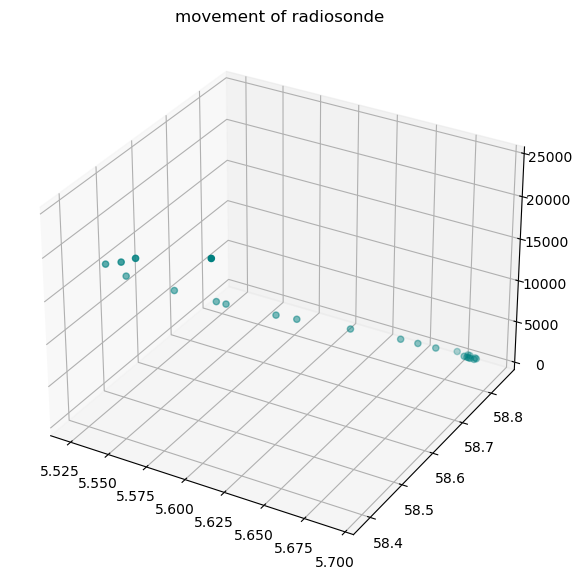

In [57]:
#find the corresponding grid points 

#points1 = []


#for i in range(np.size(df2['new_lat'])):
    
    #lat = df2['new_lat'][i]
    #lon = df2['new_long'][i]
    
    #BilinnerarPoints(filename, lat, lon)

#Removing the first row
df4 =df4.tail(-1) 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(df4['new_long'], df4['new_lat'], df4['height(m)'], color = "teal")
plt.title("movement of radiosonde")

# show plot
plt.show()  


In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import animatplot as amp

x = np.linspace(-2, 2, 41)
y = np.linspace(-2, 2, 41)
t = np.linspace(0, 2*np.pi, 30)

X, Y, T = np.meshgrid(x, y, t)"WSPD(knot)"

pcolormesh_data = np.sin(X*X+Y*Y-T)
line_data       = pcolormesh_data[20,:,:] # the slice where y=0

SyntaxError: invalid syntax (2162248352.py, line 10)

### Testing the Horizontal displacement function

Testing if the conversion from change in distance in meters to new longitude and latitude is correct

2526


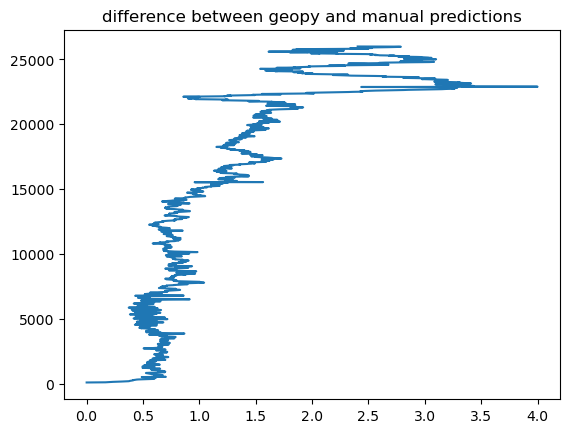

Text(0.5, 1.0, 'movment in meters')

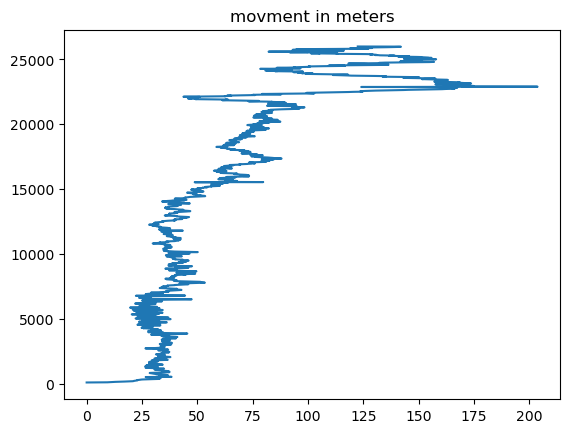

In [14]:
import geopy.distance
N = np.size(d_test[0]["new_lat"])
diff = []
height = []
for i in range(1, N):
        coords_2 = (d_test[0]["new_lat"][i], d_test[0]["new_long"][i])
        coords_1 = (d_test[0]["new_lat"][i-1], d_test[0]["new_long"][i-1])
        diff.append(geopy.distance.geodesic(coords_2, coords_1).m-d_test[1][i-1])
        height.append(d_test[0]['height(m)'][i])
        
print(N)

plt.plot(diff, height)
plt.title("difference between geopy and manual predictions")
plt.show()
plt.plot(d_test[1], height)
plt.title("movment in meters")


The error could be from the assumption that there is no krumning where the distance is meassured. The distance meassured bu the function is therefore a bit smaller. However, the distance meassured 

#### Uploading a datafile with new radiosonde data to test the horizontal displacement function

In [10]:
filename = 'aas_20211231-20220131.nc'
variables_wind =["longitude", 'latitude', 'time', "time_from_launch", "wind_speed", "wind_from_direction", "geopotential_height", "ascent_rate"]

with Dataset(filename) as ncfile:
    wind_dir=ncfile[variables_wind[5]][:]
    wind_speed=ncfile[variables_wind[4]][:]
    time=ncfile[variables_wind[2]][:]
    longitude=ncfile[variables_wind[0]][:]
    latitude=ncfile[variables_wind[1]][:]
    height = ncfile[variables_wind[6]][:]
    time_from_launch = ncfile[variables_wind[3]][:]
    ascent_rate = ncfile[variables_wind[7]][:]
    
    print(ncfile)
    print(height)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    date_created: 2022-02-01T02:55:46Z
    title: Radiosonde station time series data
    Conventions: CF-1.6
    comment: Radiosonde data produced and collected by the Norwegian Meterological Institute.
    institution: Norwegian Meterological Institute
    licence: Freely distributed. Must credit the source of data, e.g. "Data from the Norwegian Meteorological Institute", "Based on data from the Norwegian Meteorological Institute". Data and products are licensed under Norwegian license for public data (NLOD) and Creative Commons Attribution 3.0 Norway. See http://met.no/English/Data_Policy_and_Data_Services.
    source: radiosonde
    station_name: aas
    wmo_block_and_station_number: 01463
    station_latitude_degrees_north: 0.5966096000000001
    station_longitude_degrees_east: 0.10781640000000002
    station_altitude_meter: 95.0
    summary: 
    featureType: 
    dimensions(sizes): time(1), tim

      WSPD(knot)  DRCT(deg)     height(m)  longitude  latitude    x_wind  \
0       2.900000      186.0     95.099998   10.78164  59.66096 -2.884114   
1       2.900000      186.0     95.099998   10.78164  59.66096 -2.884114   
2       4.200000      186.0    108.300003   10.78163  59.66109 -4.176992   
3       4.800000      186.0    119.900002   10.78163  59.66117 -4.773705   
4       5.500000      186.0    131.399994   10.78176  59.66132 -5.469870   
...          ...        ...           ...        ...       ...       ...   
2521   62.099998      273.0  25950.900391   13.11143  59.73131  3.250063   
2522   62.200001      273.0  25962.300781   13.11355  59.73125  3.255297   
2523   62.400002      273.0  25973.699219   13.11570  59.73119  3.265764   
2524   62.500000      273.0  25985.000000   13.11795  59.73112  3.270997   
2525   62.500000      273.0  25994.800781   13.12024  59.73103  3.270997   

         y_wind    new_lat   new_long  
0     -0.303133  59.660000  10.780000  
1     -

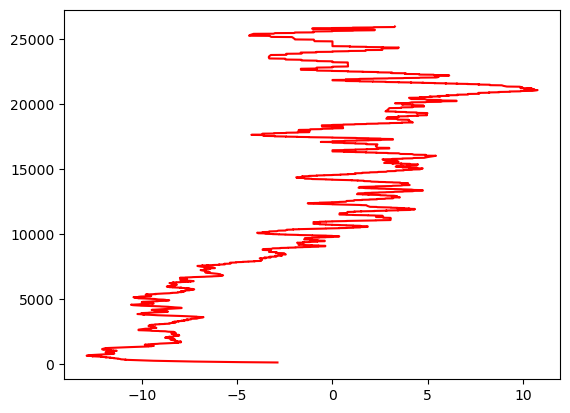

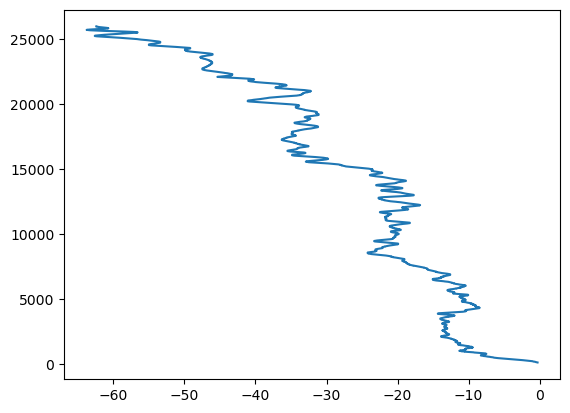

In [11]:

test_data = pd.DataFrame(wind_speed.T, columns=['WSPD(knot)'])


latitude = pd.DataFrame(latitude.T, columns=['latitude'])
latitude["latitude"] = latitude["latitude"].fillna(latitude["latitude"][0])

longitude = pd.DataFrame(longitude.T, columns=['longitude'])
longitude["longitude"] = longitude["longitude"].fillna(longitude["longitude"][0])

test_data["DRCT(deg)"] = wind_dir.T
test_data["height(m)"] = height.T
test_data["longitude"] = longitude["longitude"]
test_data["latitude"] = latitude["latitude"]



#new_data = []
#new_data.append(1)
#for i in test_data.index:
    #if i%2==0:
        #new_data.append(i)
    
    
#test_data = test_data.drop(new_data)
#test_data = test_data.reset_index()



d_test = find_horizontal_disp(test_data, 59.66, 10.78)
print(d_test[0])
plt.plot(d_test[0]['x_wind'], d_test[0]['height(m)'], 'r-')
plt.show()
plt.plot(d_test[0]['y_wind'], d_test[0]['height(m)'])
#diff = []
#N = np.size(d_test[0]["new_lat"])
#for i in range(1,N):
    
    #diff.append(d_test[0]["new_lat"][i]-latitude["latitude"][i])
    #d_test[0]["new_long"][i]-longitude.T[i]
    




0       59.660000
1       59.660000
2       59.660085
3       59.660180
4       59.660288
          ...    
2521    59.737286
2522    59.737218
2523    59.737150
2524    59.737083
2525    59.737024
Name: new_lat, Length: 2526, dtype: float64


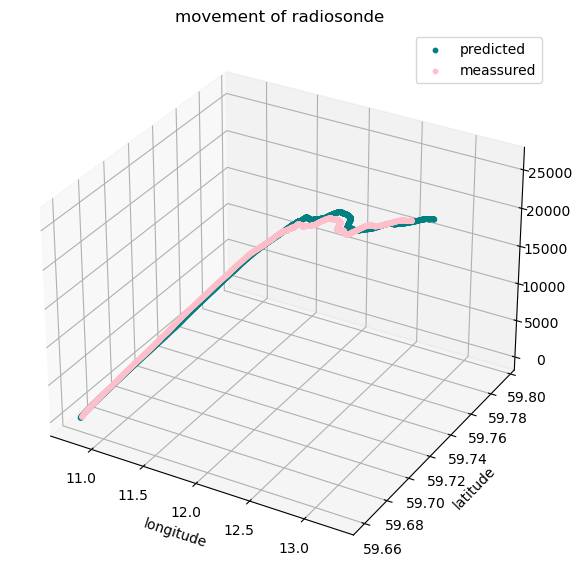

In [25]:
#df4 =df4.tail(-1) 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(d_test[0]['new_long'], d_test[0]['new_lat'], test_data['height(m)'],s=10, color = "teal")
ax.scatter3D(test_data['longitude'], test_data['latitude'], test_data['height(m)'],s=10, color = "pink")
plt.title("movement of radiosonde")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend(["predicted", "meassured"])
print(d_test[0]['new_lat'])
# show plot


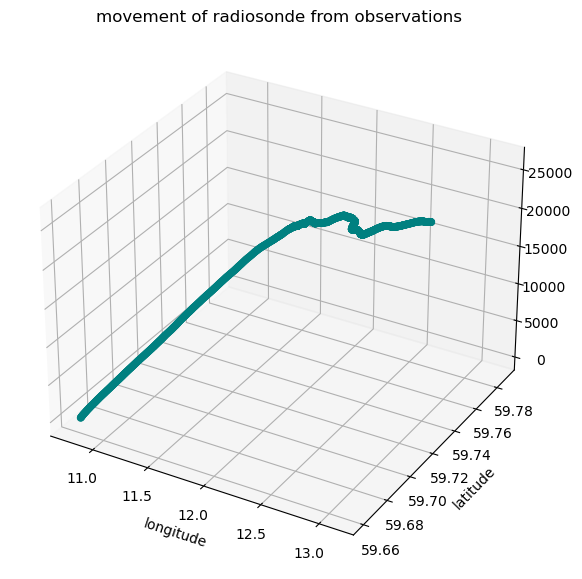

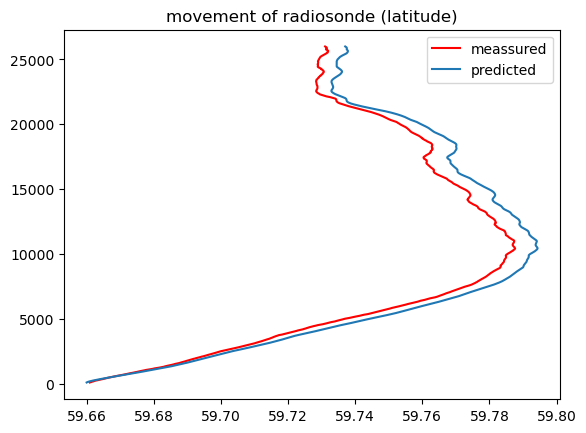

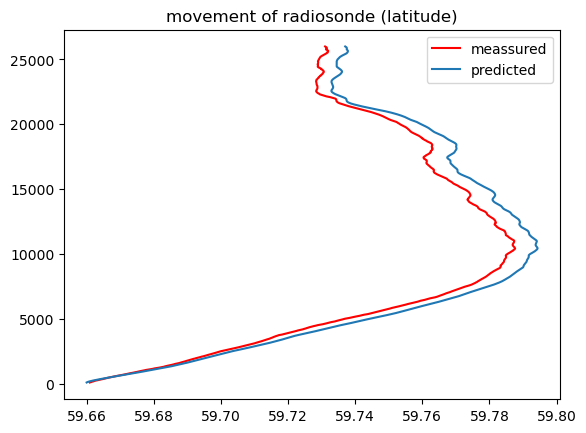

In [13]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(test_data['longitude'][:], test_data['latitude'][:], test_data['height(m)'], color = "teal")
plt.title("movement of radiosonde from observations")
plt.xlabel("longitude")
plt.ylabel("latitude")
#print(longitude['longitude'][:])
# show plot
plt.show()
plt.title("movement of radiosonde (latitude)")
line1 = plt.plot(test_data['latitude'][:], test_data['height(m)'], 'r-')
line2 = plt.plot(d_test[0]['new_lat'], test_data['height(m)'])
plt.legend(["meassured", "predicted"])
plt.show()

plt.title("movement of radiosonde (latitude)")
line1 = plt.plot(test_data['latitude'][:], test_data['height(m)'], 'r-')
line2 = plt.plot(d_test[0]['new_lat'], test_data['height(m)'])
plt.legend(["meassured", "predicted"])
plt.show()

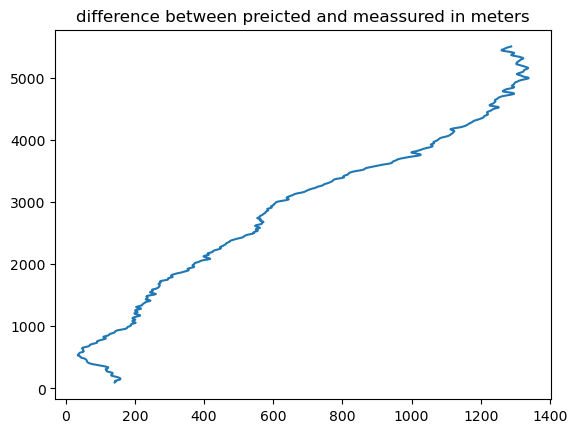

2526


15743.520867346633

In [24]:
N = np.size(d_test[0]["new_lat"])
dist_m = []
height = []
for i in range(1, N):
        coords_2 = (d_test[0]["new_lat"][i], d_test[0]["new_long"][i])
        coords_1 = (test_data["latitude"][i], test_data["longitude"][i])
        dist_m.append(geopy.distance.geodesic(coords_2, coords_1).m)
        height.append(d_test[0]['height(m)'][i])
        

plt.plot(dist_m[:500], height[:500])
plt.title("difference between preicted and meassured in meters")
plt.show()
print(N)
        
coords_2 = (d_test[0]["new_lat"][500], d_test[0]["new_long"][500])
coords_1 = (59.66, 10.7818)
geopy.distance.geodesic(coords_2, coords_1).m

[6.600002288818359, 5.799999237060547, 5.749996185302734, 5.600006103515625, 5.6999969482421875, 6.150001525878906, 6.400001525878906, 6.4499969482421875, 6.25, 6.0, 5.900001525878906, 5.849998474121094, 5.6999969482421875, 5.600006103515625, 5.4499969482421875, 5.399993896484375, 5.45001220703125, 5.399993896484375, 5.399993896484375, 5.5, 5.95001220703125, 6.399993896484375, 6.6999969482421875, 6.6999969482421875, 6.70001220703125, 6.5, 6.25, 6.0999908447265625, 6.100006103515625, 6.3000030517578125, 6.3499908447265625, 6.3000030517578125, 6.149993896484375, 5.95001220703125, 4.850006103515625, 6.899993896484375, 5.79998779296875, 5.70001220703125, 5.79998779296875, 5.899993896484375, 5.850006103515625, 5.75, 5.600006103515625, 5.5, 5.54998779296875, 5.6500244140625, 5.899993896484375, 6.04998779296875, 6.0, 5.95001220703125, 5.75, 5.54998779296875, 5.5, 5.550018310546875, 5.5999755859375, 5.550018310546875, 5.5, 5.449981689453125, 5.4000244140625, 5.29998779296875, 5.20001220703125,

5.130685575034842

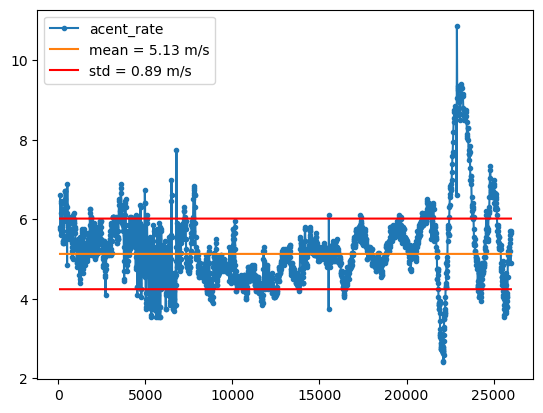

In [119]:
from statistics import mean

N = np.size(test_data["height(m)"])
v_speed = []
height2 = test_data["height(m)"].tail(-2)

# We know that the radisonde takes meassurements every 2 seconds
for i in range(2,N):
    
    diff_h = test_data["height(m)"][i]-test_data["height(m)"][i-1]
    v_speed.append(diff_h/2)
print(v_speed)
df_v = pd.DataFrame(([np.mean(v_speed)]*(N-2)))
df_std = pd.DataFrame(([np.std(v_speed)]*(N-2)))

print(df_std)
plt.plot(height2, v_speed, ".-")
plt.plot(height2, df_v)
plt.plot(height2, df_v-df_std, "-r")
plt.plot(height2, df_v+df_std, "-r")
plt.legend(["acent_rate", "mean = 5.13 m/s", "std = 0.89 m/s"])
mean(v_speed)


#### Making an animation

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation


# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='a red circle following a blue sine wave')
writer = FFMpegWriter(fps=15, metadata=metadata)

#Removing the first row
df3 =df2.tail(-1)
df5 =df4.tail(-1)
n = np.size(df3['height(m)'])
# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax = plt.axes(projection ="3d")
 
# Creating plot
#ax.scatter3D(df3['new_long'], df3['new_lat'], df3['height(m)'], color = "teal")
#plt.title("movement of radiosonde")
ax.set_ylim(0,58.4)
ax.set_xlim(5.5,5.7)
ax.set_zlim(0,25000)
ax.set(facecolor="pink")
fig.set(facecolor='red')
# show plot
plt.show()  

# plot the sine wave line

red_circle, = ax.plot3D([], [], [], 'o', color = 'teal', markersize = 5)
red_circle2, = ax.plot3D([], [], [], 'o', color = 'red', markersize = 5)

# Update the frames for the movie
with writer.saving(fig, "writer_test.mp4", 1000):
    for i in range(1,n):
        
        x0 = df3['new_long'][i]
        y0 = df3['new_lat'][i]
        z0 = df3['height(m)'][i]
        x02 = df5['new_long'][i]
        y02 = df5['new_lat'][i]
        z02 = df5['height(m)'][i]
        red_circle.set_data_3d(x0, y0, z0)
        red_circle2.set_data_3d(x02, y02, z02)
        writer.grab_frame()

RuntimeError: Requested MovieWriter (ffmpeg) not available